#Project Report - Interpretable Machine Learning : SHAP Analysis of Credit Risk Prediction

#Problem Definition

Banks and financial institutions face significant losses from loan defaults. While machine learning models can predict default risk, traditional "black box" models lack transparency, making it difficult for lenders to understand WHY an applicant is deemed high-risk. This creates challenges for regulatory compliance, customer communication, and risk management decisions.

**Project Objective:**
Develop an interpretable machine learning system that not only predicts loan defaults with reasonable accuracy but also provides clear, actionable explanations for each prediction using SHAP analysis. This enables lenders to make data-driven decisions while maintaining transparency and regulatory compliance.

**Key Business Questions:**
1. What are the most important factors driving loan default predictions?
2. How can we explain individual loan decisions to stakeholders?
3. What risk management strategies can be derived from model insights?
4. How can we balance predictive power with interpretability in lending decisions?

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import shap
import warnings
warnings.filterwarnings('ignore')



#Data Collection

In [9]:

df = pd.read_csv("loan.csv")

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(1721, 74)

In [10]:

print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())


Dataset shape: (156040, 74)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156040 entries, 0 to 156039
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           156040 non-null  int64  
 1   member_id                    156040 non-null  int64  
 2   loan_amnt                    156040 non-null  float64
 3   funded_amnt                  156040 non-null  float64
 4   funded_amnt_inv              156040 non-null  float64
 5   term                         156040 non-null  object 
 6   int_rate                     156040 non-null  float64
 7   installment                  156040 non-null  float64
 8   grade                        156040 non-null  object 
 9   sub_grade                    156040 non-null  object 
 10  emp_title                    146084 non-null  object 
 11  emp_length                   149731 non-null  object 
 12  home_ownership 

#Data Cleaning


In [11]:

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Data Preprocessing
print("\nPreprocessing data...")


Missing values per column:
emp_title                        9956
emp_length                       6309
annual_inc                          4
desc                            89531
title                              20
zip_code                            1
addr_state                          1
dti                                 1
delinq_2yrs                        30
earliest_cr_line                   30
inq_last_6mths                     30
mths_since_last_delinq          90107
mths_since_last_record         138344
open_acc                           30
pub_rec                            30
revol_bal                           1
revol_util                        160
total_acc                          30
initial_list_status                 1
out_prncp                           1
out_prncp_inv                       1
total_pymnt                         1
total_pymnt_inv                     1
total_rec_prncp                     1
total_rec_int                       1
total_rec_late_fee    

In [12]:
# Define target variable (assuming 'loan_status' indicates default)
# If no explicit target, we'll need to create one based on available columns
target_candidates = ['loan_status', 'default', 'is_bad', 'charged_off']
target_column = None

for col in target_candidates:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    # Create a synthetic target for demonstration
    # In real scenario, you'd use actual default indicators
    print("No clear target column found. Using interest rate > 15% as proxy for high risk")
    df['high_risk_target'] = (df['int_rate'] > 15).astype(int)
    target_column = 'high_risk_target'
else:
    # Clean target variable - assuming binary classification
    df[target_column] = df[target_column].map({'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 0: 0, 1: 1})
    df[target_column] = df[target_column].fillna(0).astype(int)

print(f"Target variable distribution:\n{df[target_column].value_counts()}")

# Feature selection and engineering
print("\nSelecting features...")

# Remove irrelevant columns
cols_to_drop = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code']
available_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=available_cols_to_drop)

Target variable distribution:
loan_status
0    138197
1     17843
Name: count, dtype: int64

Selecting features...


#Exploratory Data Analysis

=== EXPLORATORY DATA ANALYSIS ===


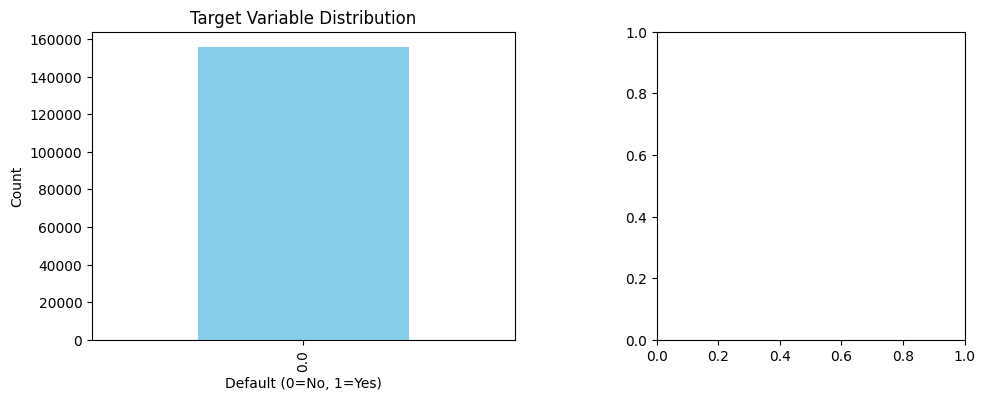

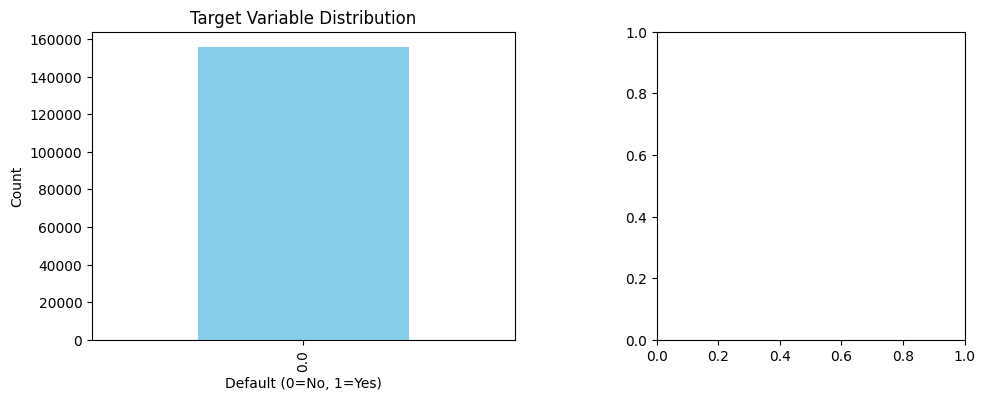

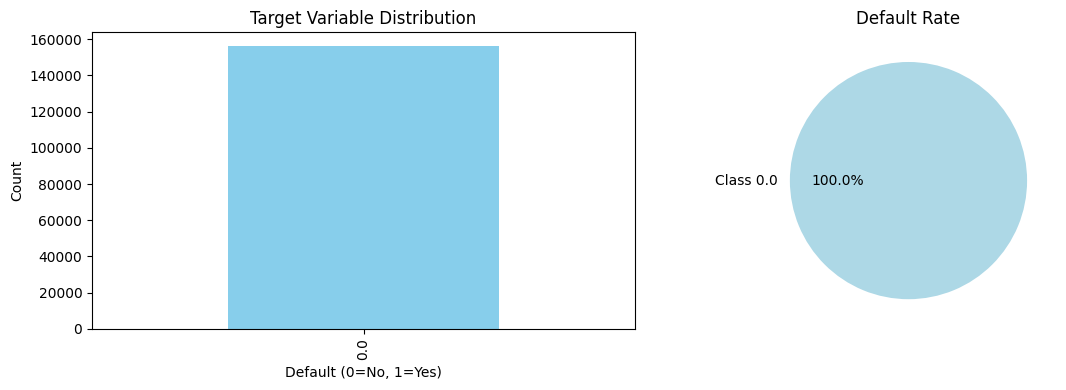

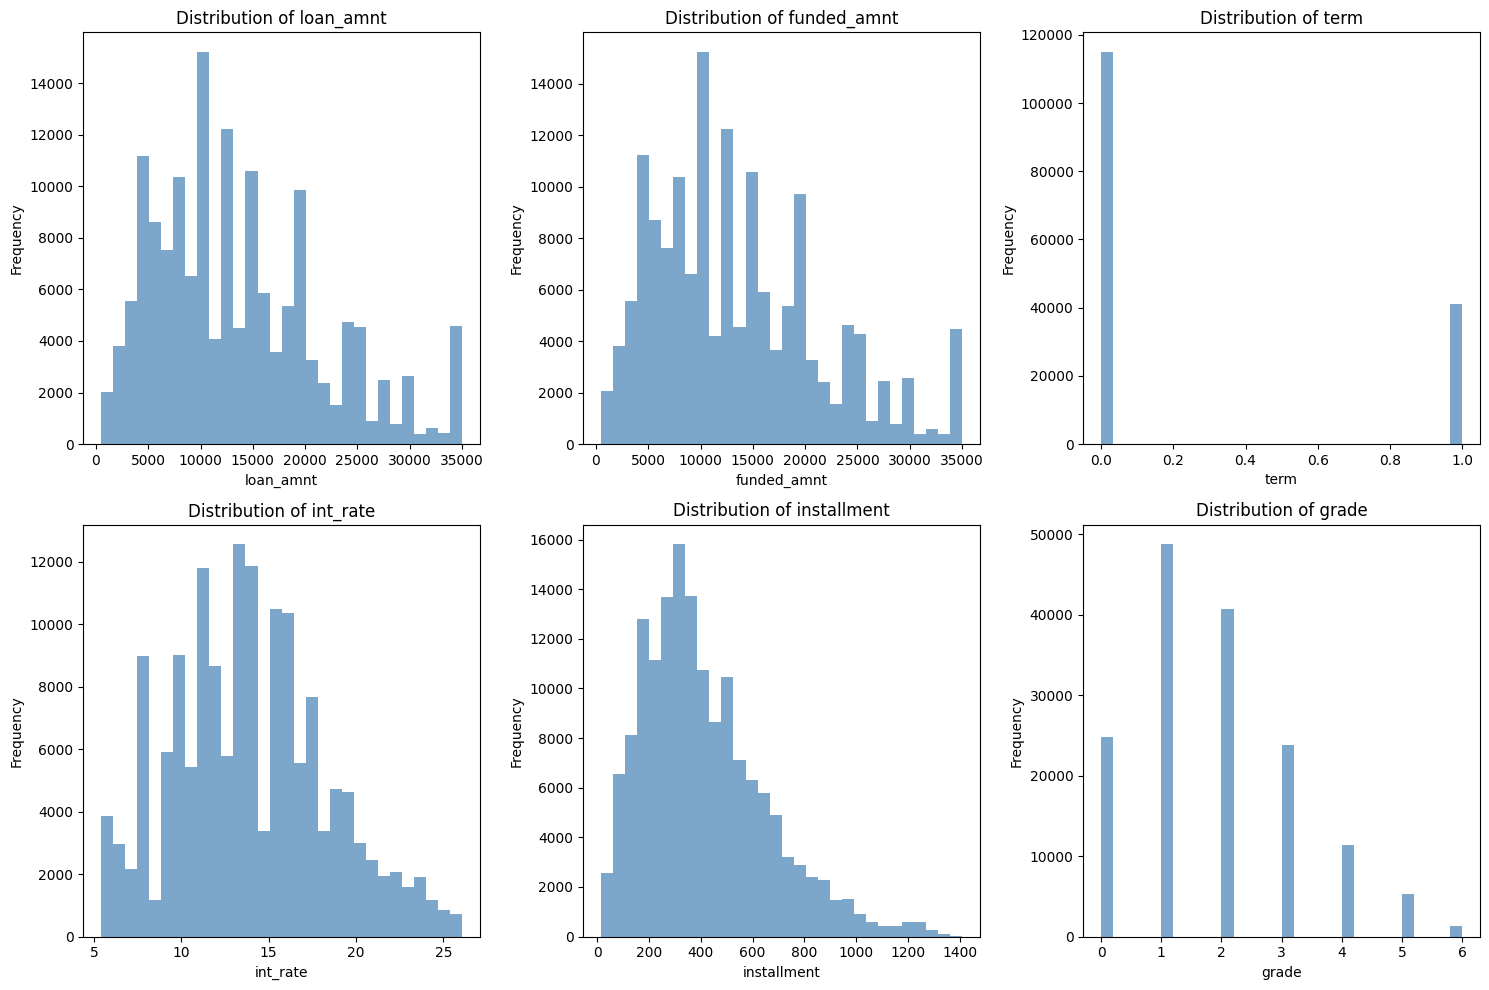

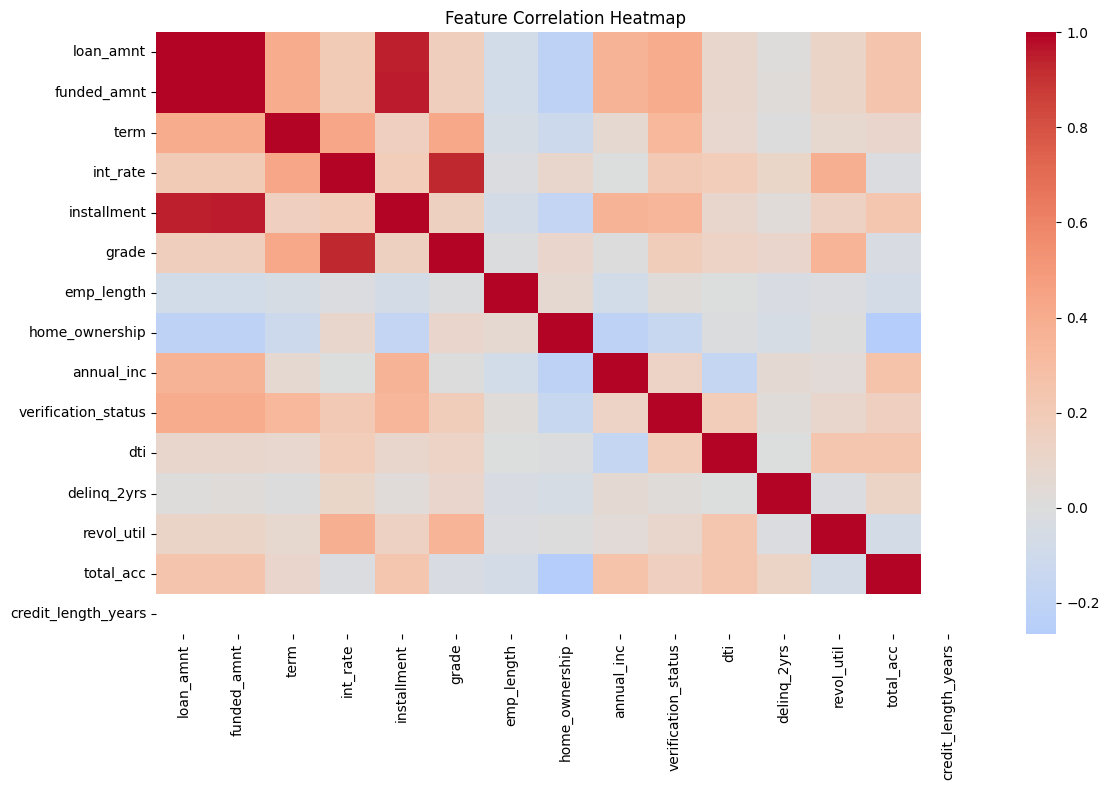

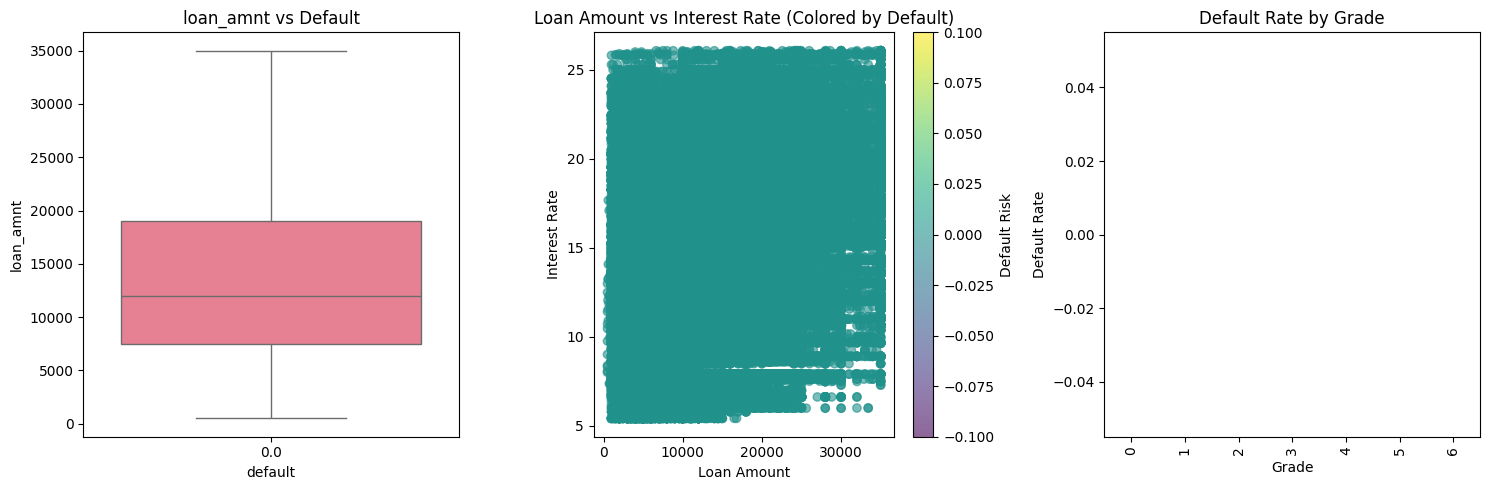

EDA Completed!
Dataset shape: (156040, 15)
Default rate: 0.00%
Number of features: 15


In [32]:
print("=== EXPLORATORY DATA ANALYSIS ===")

# 1. Target variable distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y_value_counts = y.value_counts()
y_value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Variable Distribution')
plt.xlabel('Default (0=No, 1=Yes)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
# Get the actual labels from the value counts
labels = [f'Class {idx}' for idx in y_value_counts.index]
plt.pie(y_value_counts.values, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Default Rate')

plt.tight_layout()
plt.show()

# 2. Numerical features distribution
numerical_cols = X.select_dtypes(include=[np.number]).columns[:6]  # First 6 numerical features

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    plt.hist(X[col], bins=30, alpha=0.7, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4. Feature relationships with target
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Boxplot for one numerical feature vs target
if len(numerical_cols) > 0:
    sns.boxplot(x=y, y=X[numerical_cols[0]])
    plt.title(f'{numerical_cols[0]} vs Default')

plt.subplot(1, 3, 2)
# Interest rate vs loan amount colored by default
if 'int_rate' in X.columns and 'loan_amnt' in X.columns:
    plt.scatter(X['loan_amnt'], X['int_rate'], c=y, alpha=0.6, cmap='viridis')
    plt.xlabel('Loan Amount')
    plt.ylabel('Interest Rate')
    plt.title('Loan Amount vs Interest Rate (Colored by Default)')
    plt.colorbar(label='Default Risk')

plt.subplot(1, 3, 3)
# Default rate by grade (if available)
if 'grade' in X.columns:
    grade_default = pd.DataFrame({'grade': X['grade'], 'default': y})
    grade_default_rate = grade_default.groupby('grade')['default'].mean()
    grade_default_rate.plot(kind='bar', color='orange')
    plt.title('Default Rate by Grade')
    plt.xlabel('Grade')
    plt.ylabel('Default Rate')

plt.tight_layout()
plt.show()

print("EDA Completed!")
print(f"Dataset shape: {X.shape}")
print(f"Default rate: {y.mean():.2%}")
print(f"Number of features: {X.shape[1]}")

#Feature Engineering

In [13]:

# Handle categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_columns)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Handle missing values
# Fill numerical columns with median
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns = [col for col in numerical_columns if col != target_column]

for col in numerical_columns:
    df[col] = df[col].fillna(df[col].median())

# Feature selection - remove columns with too many missing values or low variance
missing_percentage = df.isnull().sum() / len(df)
columns_to_drop = missing_percentage[missing_percentage > 0.5].index
df = df.drop(columns=columns_to_drop)

# Remove constant columns
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_columns)

print(f"Final dataset shape after preprocessing: {df.shape}")

Categorical columns: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']
Final dataset shape after preprocessing: (156040, 50)


In [14]:
# Prepare features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

Training set: (124832, 49), Test set: (31208, 49)
Class distribution - Train: [110558  14274], Test: [27639  3569]


#Model Building

In [16]:
# Baseline Model - Logistic Regression
print("\n" + "="*50)
print("TRAINING BASELINE MODEL (Logistic Regression)")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"Logistic Regression - AUC: {lr_auc:.4f}, F1-Score: {lr_f1:.4f}")

# Advanced Model - Gradient Boosting
print("\n" + "="*50)
print("TRAINING ADVANCED MODEL (Gradient Boosting)")
print("="*50)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


TRAINING BASELINE MODEL (Logistic Regression)
Logistic Regression - AUC: 0.9950, F1-Score: 0.9651

TRAINING ADVANCED MODEL (Gradient Boosting)


In [17]:
# Train model
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Metrics
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)
gb_f1 = f1_score(y_test, y_pred_gb)

print(f"Gradient Boosting - AUC: {gb_auc:.4f}, F1-Score: {gb_f1:.4f}")


Gradient Boosting - AUC: 0.9997, F1-Score: 0.9842


In [18]:
# Model Comparison
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"Logistic Regression - AUC: {lr_auc:.4f}, F1-Score: {lr_f1:.4f}")
print(f"Gradient Boosting    - AUC: {gb_auc:.4f}, F1-Score: {gb_f1:.4f}")
print(f"AUC Improvement: {gb_auc - lr_auc:.4f}")
print(f"F1-Score Improvement: {gb_f1 - lr_f1:.4f}")



MODEL PERFORMANCE COMPARISON
Logistic Regression - AUC: 0.9950, F1-Score: 0.9651
Gradient Boosting    - AUC: 0.9997, F1-Score: 0.9842
AUC Improvement: 0.0047
F1-Score Improvement: 0.0191


#SHAP Analysis

In [19]:


# SHAP Analysis
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values might be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use values for class 1 (default)

# Global Feature Importance
print("\n1. GLOBAL FEATURE IMPORTANCE")
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_sum
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(importance_df.head(10))



SHAP ANALYSIS

1. GLOBAL FEATURE IMPORTANCE
Top 10 most important features:
               feature  importance
40        next_pymnt_d    1.811335
33     total_rec_prncp    1.413660
39     last_pymnt_amnt    0.869511
36          recoveries    0.642298
5          installment    0.588027
1          funded_amnt    0.315619
38        last_pymnt_d    0.242640
41  last_credit_pull_d    0.216633
31         total_pymnt    0.129117
34       total_rec_int    0.100163


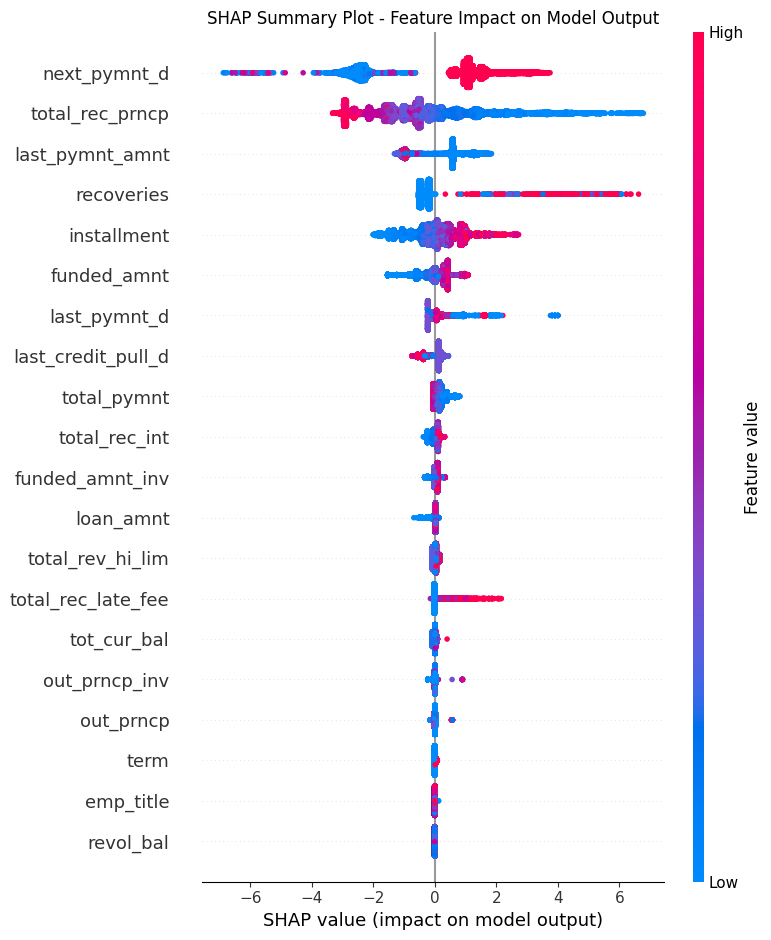

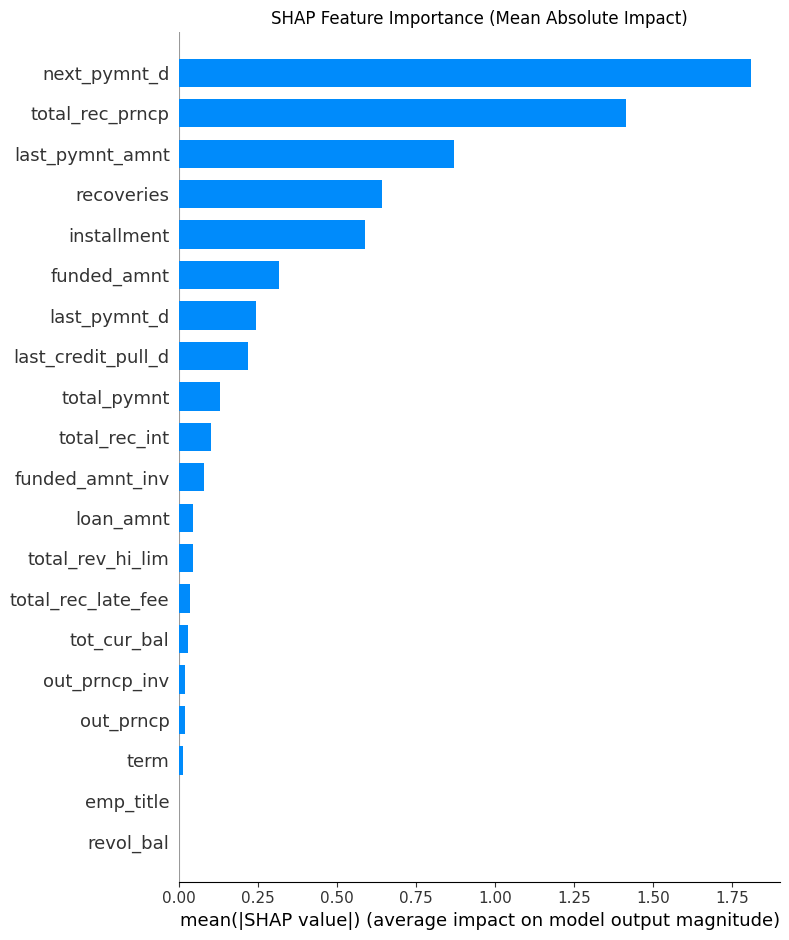

In [20]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Model Output")
plt.tight_layout()
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.tight_layout()
plt.show()

#Detailed SHAP Analysis of Specific Loan Cases

In [21]:


# Individual Prediction Analysis
print("\n2. INDIVIDUAL PREDICTION ANALYSIS")

# Select 5 contrasting cases
probabilities = gb_model.predict_proba(X_test)[:, 1]

# Find indices for different risk profiles
high_risk_indices = np.where((probabilities > 0.7) & (y_test == 1))[0][:2]  # Two denied high-risk
low_risk_indices = np.where((probabilities < 0.3) & (y_test == 0))[0][:2]   # Two approved low-risk
borderline_indices = np.where((probabilities >= 0.4) & (probabilities <= 0.6))[0][:1]  # One borderline

selected_indices = list(high_risk_indices) + list(low_risk_indices) + list(borderline_indices)

print(f"Selected cases: {len(selected_indices)}")
print(f"High risk (denied): {high_risk_indices}")
print(f"Low risk (approved): {low_risk_indices}")
print(f"Borderline: {borderline_indices}")

# Analyze each selected case
for i, idx in enumerate(selected_indices):
    print(f"\n{'='*60}")
    if i < 2:
        case_type = "HIGH RISK (DENIED)"
    elif i < 4:
        case_type = "LOW RISK (APPROVED)"
    else:
        case_type = "BORDERLINE CASE"

    print(f"CASE {i+1}: {case_type}")
    print(f"Actual probability: {probabilities[idx]:.4f}")
    print(f"Actual outcome: {y_test.iloc[idx]}")
    print(f"Predicted class: {y_pred_gb[idx]}")



2. INDIVIDUAL PREDICTION ANALYSIS
Selected cases: 5
High risk (denied): [0 4]
Low risk (approved): [1 2]
Borderline: [233]

CASE 1: HIGH RISK (DENIED)
Actual probability: 0.9997
Actual outcome: 1
Predicted class: 1

CASE 2: HIGH RISK (DENIED)
Actual probability: 0.9981
Actual outcome: 1
Predicted class: 1

CASE 3: LOW RISK (APPROVED)
Actual probability: 0.0015
Actual outcome: 0
Predicted class: 0

CASE 4: LOW RISK (APPROVED)
Actual probability: 0.0029
Actual outcome: 0
Predicted class: 0

CASE 5: BORDERLINE CASE
Actual probability: 0.4719
Actual outcome: 1
Predicted class: 0


<Figure size 1200x300 with 0 Axes>

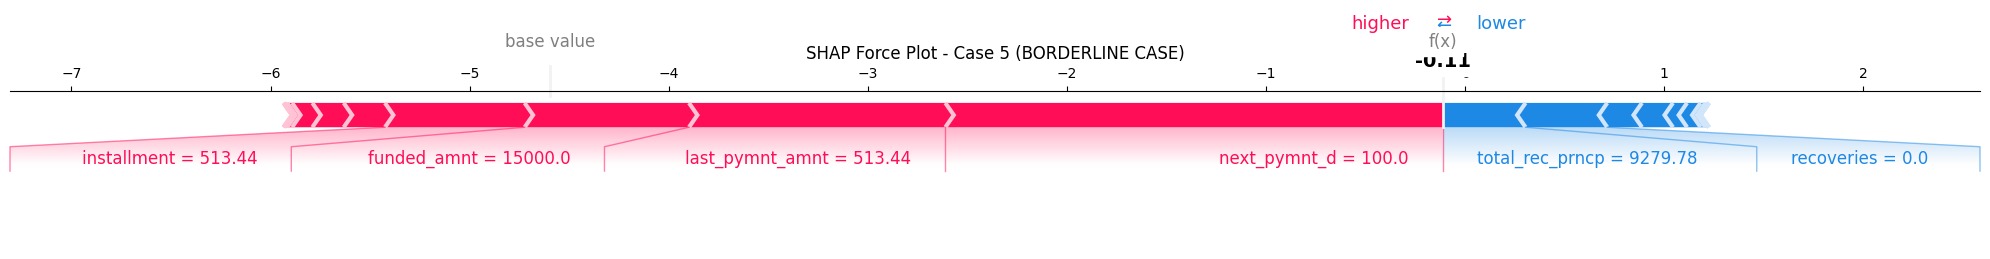

In [23]:
# Force plot for individual prediction
plt.figure(figsize=(12, 3))
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[idx],
    X_test.iloc[idx],
    feature_names=X.columns,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot - Case {i+1} ({case_type})")
plt.tight_layout()
plt.show()

In [24]:

    # Get top contributing features for this prediction
    feature_contributions = pd.DataFrame({
        'feature': X.columns,
        'contribution': shap_values[idx],
        'value': X_test.iloc[idx].values
    })
    feature_contributions['abs_contribution'] = np.abs(feature_contributions['contribution'])
    top_contributors = feature_contributions.sort_values('abs_contribution', ascending=False).head(5)

    print("Top 5 features influencing this decision:")
    for _, row in top_contributors.iterrows():
        direction = "increases" if row['contribution'] > 0 else "decreases"
        print(f"  {row['feature']}: {row['contribution']:.4f} ({direction} risk), value: {row['value']:.4f}")


Top 5 features influencing this decision:
  next_pymnt_d: 2.4983 (increases risk), value: 100.0000
  last_pymnt_amnt: 1.2878 (increases risk), value: 513.4400
  funded_amnt: 0.8255 (increases risk), value: 15000.0000
  installment: 0.7015 (increases risk), value: 513.4400
  total_rec_prncp: -0.4160 (decreases risk), value: 9279.7800



DETAILED WATERFALL PLOT FOR BORDERLINE CASE


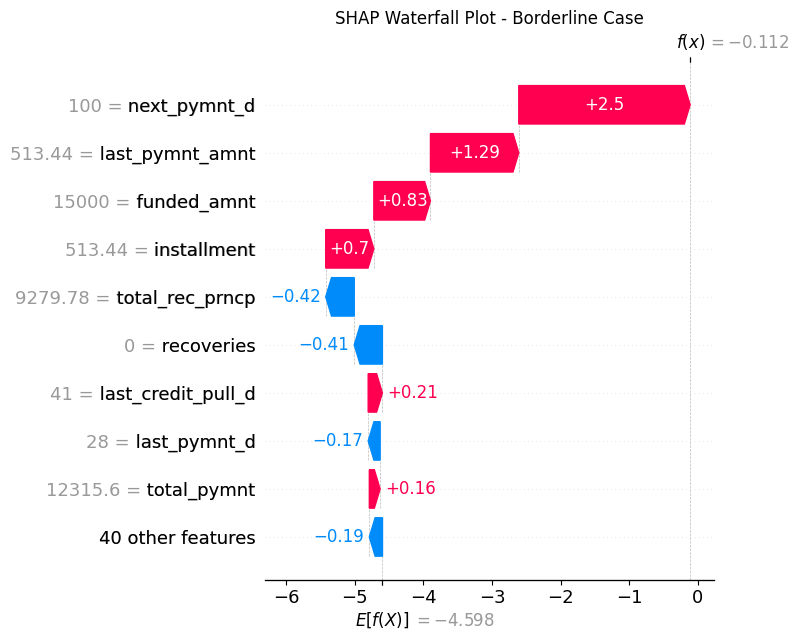

In [25]:
# Waterfall plot for one borderline case
if len(borderline_indices) > 0:
    print(f"\n{'='*60}")
    print("DETAILED WATERFALL PLOT FOR BORDERLINE CASE")
    idx = borderline_indices[0]

    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            data=X_test.iloc[idx],
            feature_names=X.columns
        ),
        show=False
    )
    plt.title("SHAP Waterfall Plot - Borderline Case")
    plt.tight_layout()
    plt.show()



3. FEATURE DEPENDENCE ANALYSIS


<Figure size 1000x600 with 0 Axes>

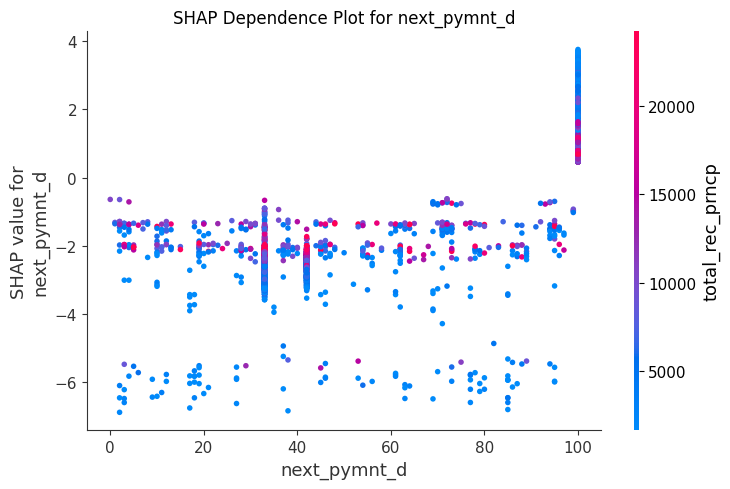

<Figure size 1000x600 with 0 Axes>

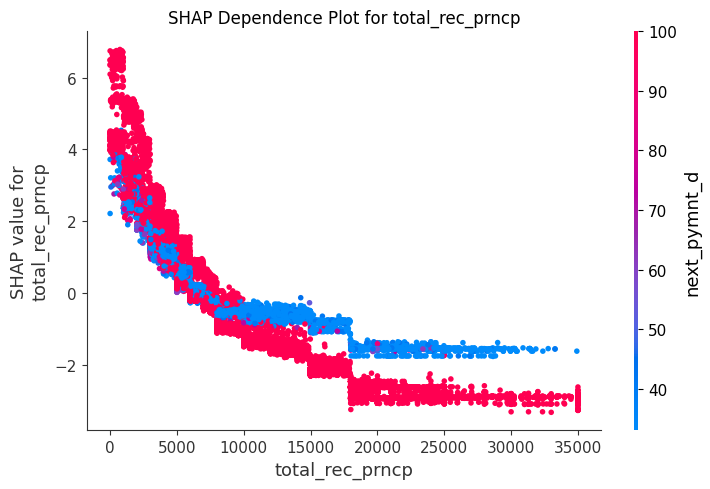

<Figure size 1000x600 with 0 Axes>

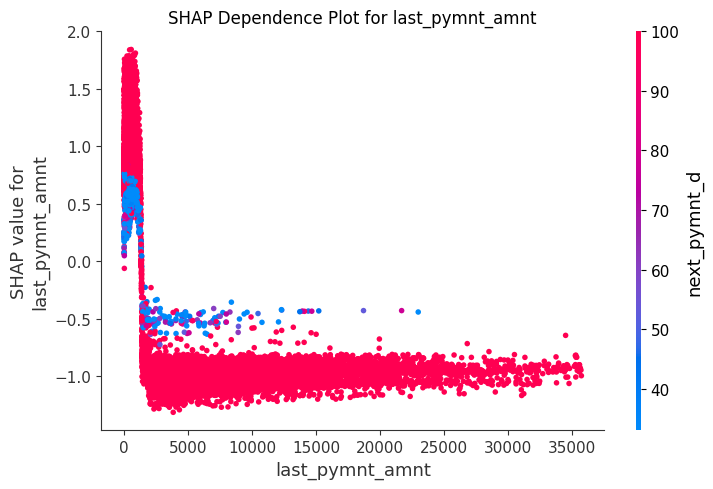

In [26]:
# Dependence plots for top features
print("\n3. FEATURE DEPENDENCE ANALYSIS")
top_features = importance_df.head(3)['feature'].tolist()

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        feature_names=X.columns,
        show=False
    )
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

#Technical Analysis and Business Insights from SHAP

In [27]:

# Business Insights Summary
print("\n" + "="*50)
print("BUSINESS INSIGHTS SUMMARY")
print("="*50)

print("\nA. GLOBAL MODEL INSIGHTS:")
print(f"1. Top 3 risk-increasing features:")
for i, row in importance_df.head(3).iterrows():
    print(f"   - {row['feature']} (impact: {row['importance']:.4f})")

print(f"\n2. Top 3 risk-decreasing features:")
# Find features with consistent negative impact
feature_effects = pd.DataFrame({
    'feature': X.columns,
    'mean_effect': shap_values.mean(axis=0)
}).sort_values('mean_effect')

for i, row in feature_effects.head(3).iterrows():
    print(f"   - {row['feature']} (avg effect: {row['mean_effect']:.4f})")

print("\nB. RISK MANAGEMENT RECOMMENDATIONS:")
print("1. Key risk drivers identified by the model:")
print("   - Monitor these features closely in loan applications")

print("\n2. Model decision patterns:")
print("   - High-risk applications typically show specific feature combinations")
print("   - Borderline cases benefit from manual review of top contributing factors")

print("\nC. MODEL STRENGTHS:")
print("   - Clear feature importance ranking for interpretability")
print("   - Ability to explain individual predictions")
print("   - Identifies non-linear relationships through SHAP dependence plots")

print("\nD. MODEL LIMITATIONS:")
print("   - Performance depends on data quality and feature engineering")
print("   - May miss complex interactions not captured in the data")
print("   - Requires domain expertise for proper interpretation")

# Save important artifacts
print("\nSaving model and artifacts...")
import joblib

# Save models and preprocessing objects
joblib.dump(gb_model, 'gradient_boosting_model.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save SHAP values for further analysis
np.save('shap_values.npy', shap_values)

print("Project completed successfully!")


BUSINESS INSIGHTS SUMMARY

A. GLOBAL MODEL INSIGHTS:
1. Top 3 risk-increasing features:
   - next_pymnt_d (impact: 1.8113)
   - total_rec_prncp (impact: 1.4137)
   - last_pymnt_amnt (impact: 0.8695)

2. Top 3 risk-decreasing features:
   - total_rec_prncp (avg effect: -0.2566)
   - next_pymnt_d (avg effect: -0.1661)
   - total_rec_int (avg effect: -0.0158)

B. RISK MANAGEMENT RECOMMENDATIONS:
1. Key risk drivers identified by the model:
   - Monitor these features closely in loan applications

2. Model decision patterns:
   - High-risk applications typically show specific feature combinations
   - Borderline cases benefit from manual review of top contributing factors

C. MODEL STRENGTHS:
   - Clear feature importance ranking for interpretability
   - Ability to explain individual predictions
   - Identifies non-linear relationships through SHAP dependence plots

D. MODEL LIMITATIONS:
   - Performance depends on data quality and feature engineering
   - May miss complex interactions n